In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm

sns.set()


In [2]:
def switchpoint(data,country):
    
    
    alpha = 1 / pm.Normal('alpha',mu=data.median(),tau = 1 / data.std() ** 2)

    try:
        lambda_1 = pm.Exponential('lambda_1',alpha)
    except:
        print ('cant assign priors to {}'.format(country))
        return None
    
    lambda_2 = pm.Exponential('lambda_2',alpha)
    lambda_3 = pm.Exponential('lambda_3',alpha)

    obs_sigma = pm.Normal('obs_sigma',data.mean(),1 / data.std() ** 2)

    tau = pm.DiscreteUniform('tau',lower=0,upper=data.size) #switchpoint-day
    tau_2 = pm.DiscreteUniform('tau_2',lower=0,upper=data.size - 1)
    
    @pm.deterministic()
    def lambda_ (tau=tau, tau_2=tau_2,lambda_1=lambda_1,lambda_2=lambda_2,lambda_3=lambda_3):
        out = np.zeros(data.size)
        out[:tau] = lambda_1 # param (eg inc) value before switch
        out[tau:tau_2] = lambda_2 # param value after switch
        out[tau_2:] = lambda_3
        return out


    obs = pm.Normal('obs',lambda_,obs_sigma,observed=True,value=data)

    model = pm.Model([lambda_1,lambda_2,lambda_3,lambda_,tau,tau_2,obs,alpha,obs_sigma])

    try:
        map_ = pm.MAP(model)
        map_.fit()
    
    except:
        print ('cant fit {}'.format(country_name))
    
    mcmc = pm.MCMC(model)
    mcmc.sample(100000,50000,2)

    lambda_1_post = mcmc.trace('lambda_1')[:]
    lambda_2_post =  mcmc.trace('lambda_2')[:]
    lambda_3_post = mcmc.trace('lambda_3')[:]
    
    tau_post = mcmc.trace('tau')[:]
    tau_2_post = mcmc.trace('tau_2')[:]
    
    result = pd.DataFrame({'lambda_1_post' : lambda_1_post,
                                'lambda_2_post': lambda_2_post,
                                'lambda_3_post' : lambda_3_post,
                                'tau_post': tau_post,
                                'tau_2_post' : tau_2_post})

    print ()
    print (result.describe())
    print (data.tail(40))

    return result

In [3]:
def plot(data,df,result,param,country_name):
    
    expected_values_per_day = np.zeros(data.size)

    N = 10000

    tau_samples = np.random.choice(result.tau_post,replace=True,size=N)
    tau_2_samples = np.random.choice(result.tau_2_post,replace=True,size=N)
    lambda_1_samples = np.random.choice(result.lambda_1_post,replace=True,size=N)
    lambda_2_samples = np.random.choice(result.lambda_2_post,replace=True,size=N)
    lambda_3_samples = np.random.choice(result.lambda_3_post,replace=True,size=N)
    
    for day in range(0,data.size):
        ix = day < tau_samples
        ix3 = day >= tau_2_samples
        ix2 = ~(ix | ix3)
        
        expected_values_per_day[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[ix2].sum() + \
                                       lambda_3_samples[ix3].sum()) / N
    
    plt.figure(figsize=(18,12))

    bins = len(data)

    plt.title('Posteriors Exponential Distribution for {}'.format(country_name))
    plt.hist(result.lambda_1_post,
             density=True,
             bins=bins,
             color='g',
             alpha=0.7,
             label='Lambda1 param for prior (==EV) before switchpoint for {}'.format(param))

    plt.hist(result.lambda_2_post,
             density=True,
             bins=bins,
             color='r',
             alpha=0.7,
             label='Lambda2 param for prior (==EV) after switchpoint for {}'.format(param))
    
    plt.hist(result.lambda_3_post,
             density=True,
             bins=bins,
             color='navy',
             alpha=0.7,
             label='Lambda3 param for prior (==EV) after 2:d switchpoint for {}'.format(param))
    
    plt.xlabel('Posterior Distribution for {} before and after switchpoint'.format(param))
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.savefig('Corona_switchpoint_params_{}_{}_.jpg'.format(country_name,param),format='jpg')

    fig,axes = plt.subplots(3,1,sharex=True,figsize=(18,12))
    
    w = 1 / result.tau_post.shape[0] * np.ones_like(result.tau_post)
    
    axes[0].set_title('Probability of a change of {} occuring on specific day for {}'.format(param,country_name))
    axes[0].set_ylabel('Probability')
    axes[0].set_xlabel('Day number after number of confirmed hit {}'.format(filter))
    axes[0].hist(result.tau_post,bins=bins,align='left',rwidth=1,weights=w)

    w = 1 / result.tau_2_post.shape[0] * np.ones_like(result.tau_2_post)
    
    axes[1].set_title('Probability of second change of {} occuring on specific day for {}'.format(param,country_name))
    axes[1].set_ylabel('Probability')
    axes[1].set_xlabel('Day number after number of confirmed hit {}'.format(filter))
    axes[1].hist(result.tau_2_post,bins=bins,align='left',rwidth=1,weights=w)
    
    axes[2].bar(df.day_nr,df[param],width=1)
    axes[2].set_title('Parameter {} value on specific day for {}'.format(param,country_name))
    axes[2].set_ylabel('Parameter value')
    axes[2].set_xlabel('Day number after number of confirmed hit {}'.format(filter))

    axes[2].plot(expected_values_per_day,color='orange',
             label='Expected Value of {}, before and after switchpoint'.format(param))
    axes[2].legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Corona_switchpoint_EV_{}_{}_.jpg'.format(country_name,param),format='jpg')




++++++++++   Italy   +++++++++++
 [-----------------100%-----------------] 100000 of 100000 complete in 38.3 sec
       lambda_1_post  lambda_2_post  lambda_3_post      tau_post    tau_2_post
count   25000.000000   25000.000000   25000.000000  25000.000000  25000.000000
mean      138.242661     120.738766     109.982321      5.479200     17.072720
std         4.631386      21.837464       1.904988      5.324575      2.143776
min        75.999618       0.152376      95.156233      0.000000      4.000000
25%       136.295796     121.406539     108.882917      4.000000     16.000000
50%       138.840591     122.945196     110.031670      4.000000     17.000000
75%       141.213531     124.381480     111.195388      4.000000     17.000000
max       163.684639     428.175794     119.329234     32.000000     31.000000
2020-02-27    144.591611
2020-02-28    135.572519
2020-02-29    127.027027
2020-03-01    150.177305
2020-03-02    120.188902
2020-03-03    122.888016
2020-03-04    123.461231



++++++++++   Netherlands   +++++++++++
 [-----------------100%-----------------] 100000 of 100000 complete in 51.0 sec
       lambda_1_post  lambda_2_post  lambda_3_post      tau_post   tau_2_post
count   25000.000000   25000.000000   25000.000000  25000.000000  25000.00000
mean      132.842325     154.747283     117.036245      1.648600      2.30032
std         5.916533      24.989841       1.636439      2.720216      1.83236
min       112.225311       0.087185      79.865766      0.000000      1.00000
25%       129.115004     156.539930     116.452825      1.000000      2.00000
50%       132.081178     159.722239     117.137896      1.000000      2.00000
75%       135.315903     162.718485     117.830985      1.000000      2.00000
max       161.706134     368.956067     123.369861     19.000000     18.00000
2020-03-11    131.675393
2020-03-13    160.238569
2020-03-14    119.354839
2020-03-15    118.295218
2020-03-16    124.428822
2020-03-17    120.833333
2020-03-18    120.280538
202

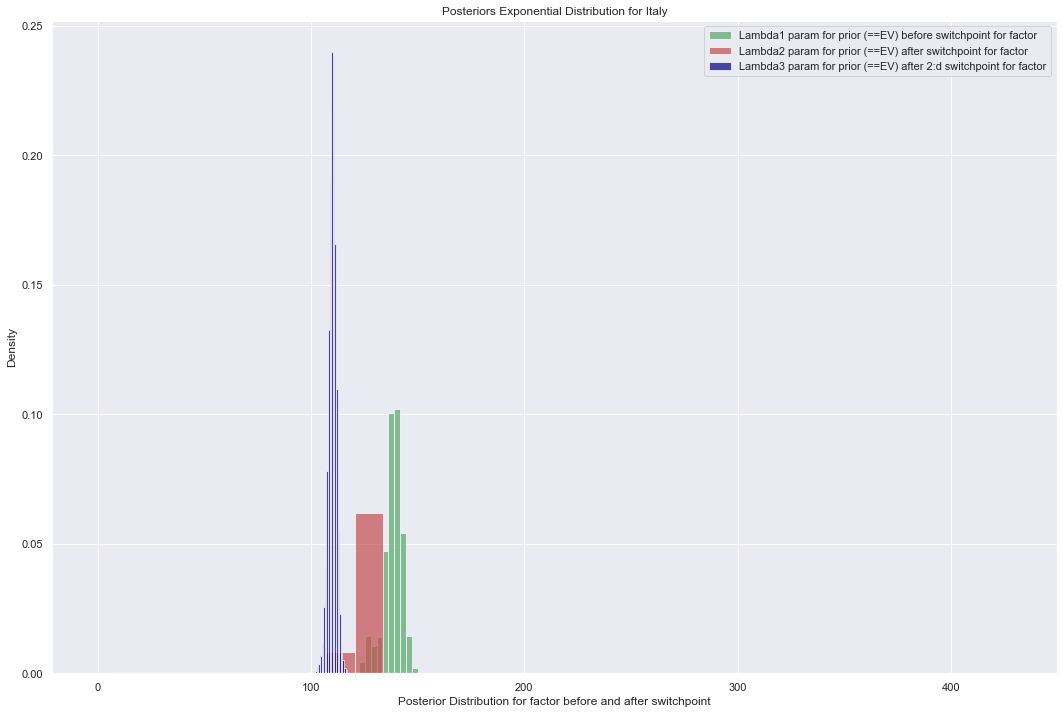

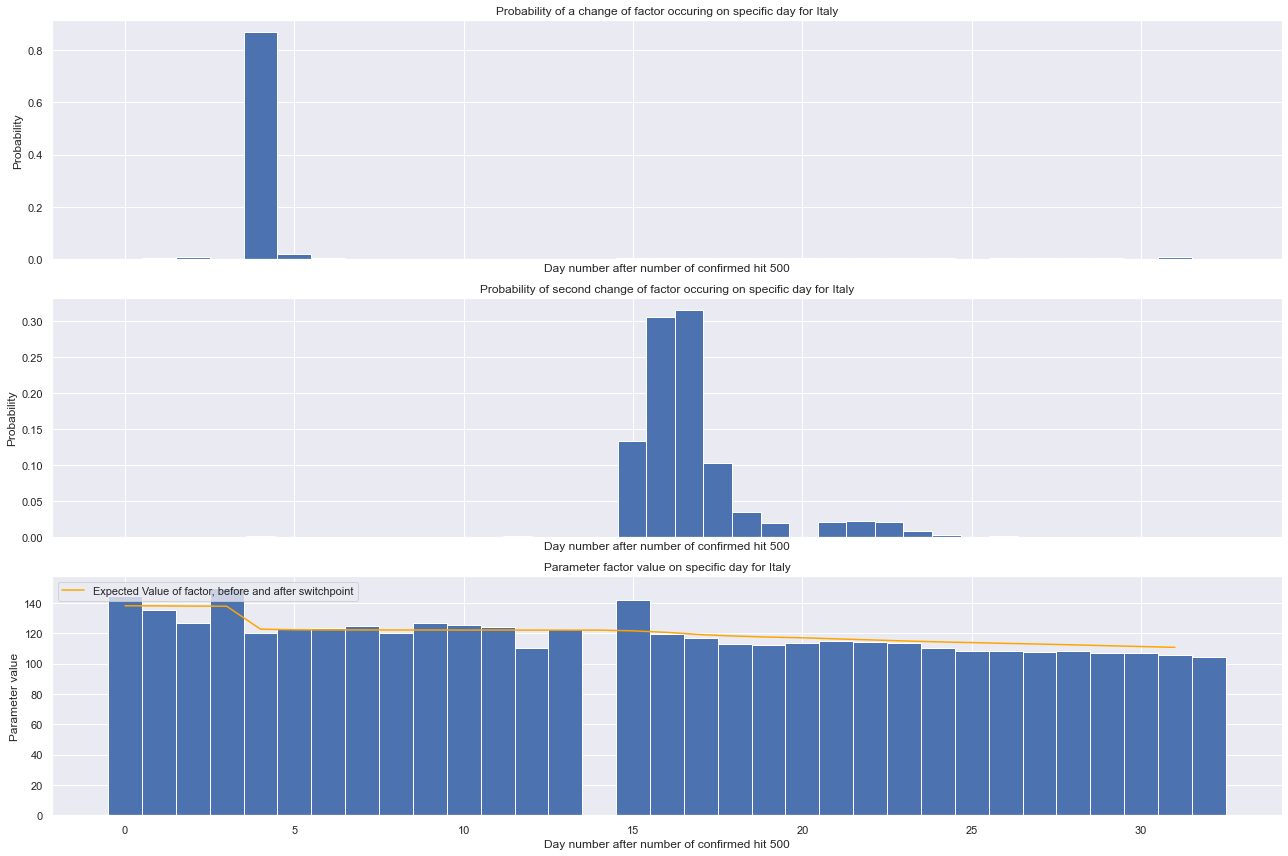

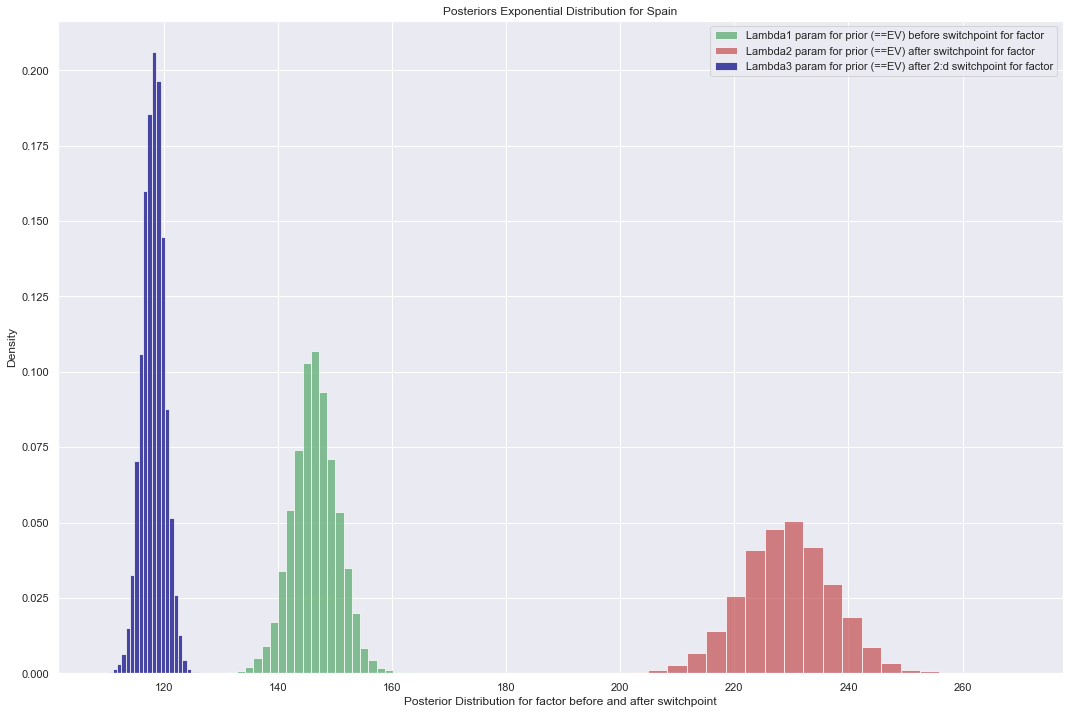

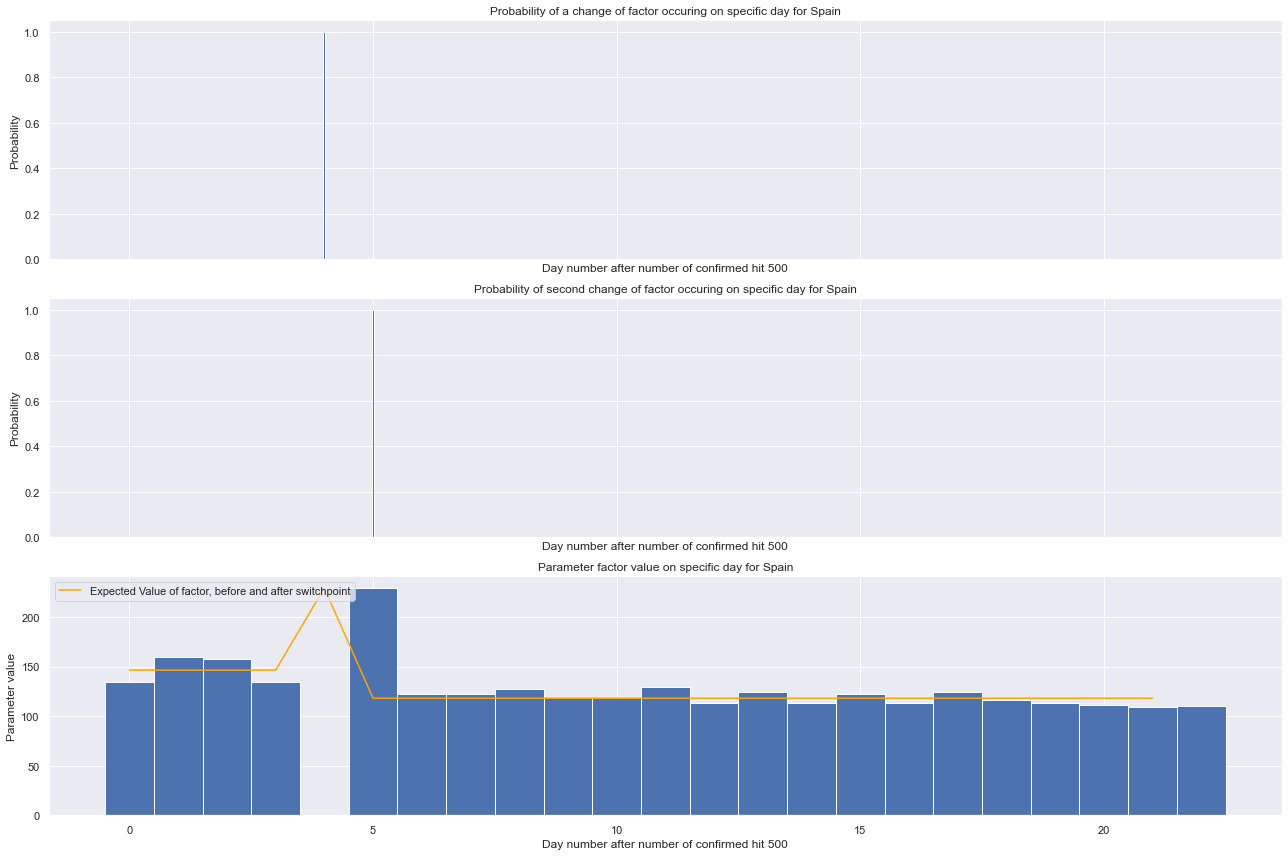

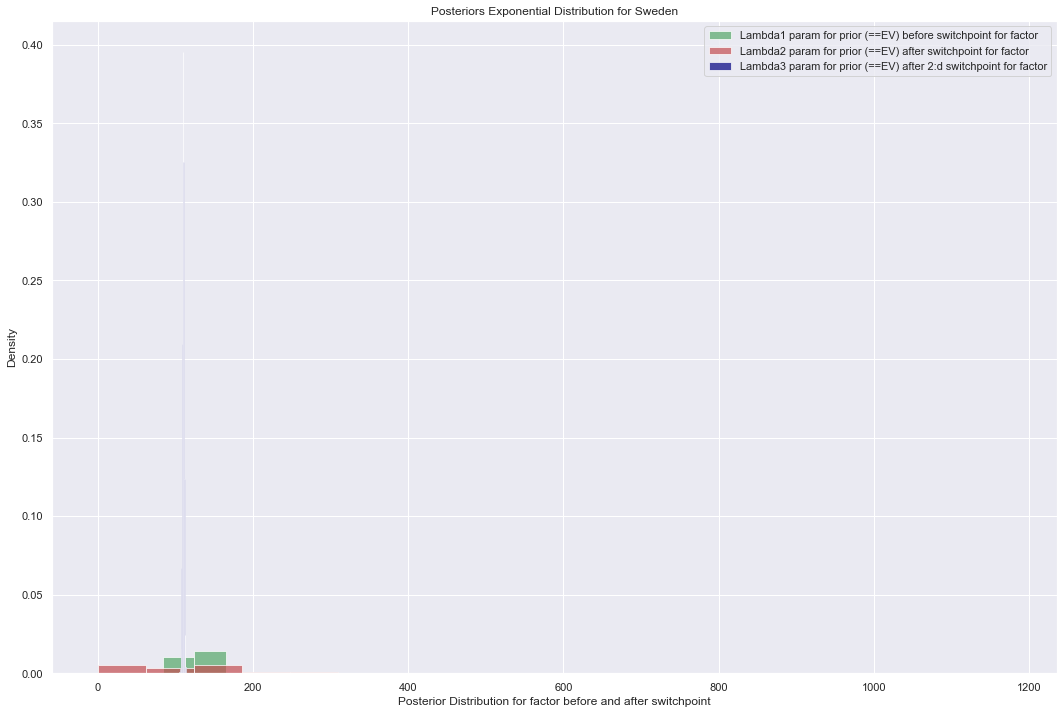

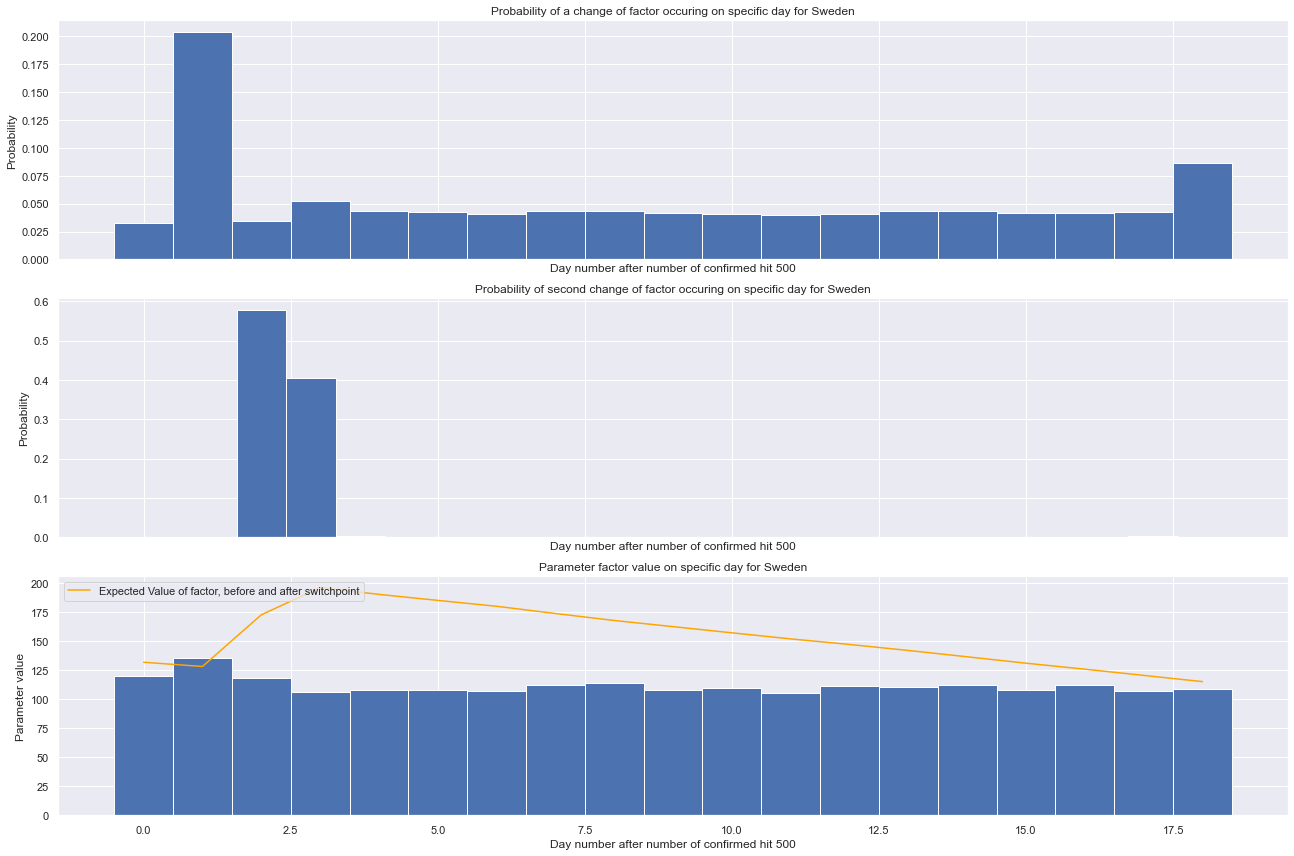

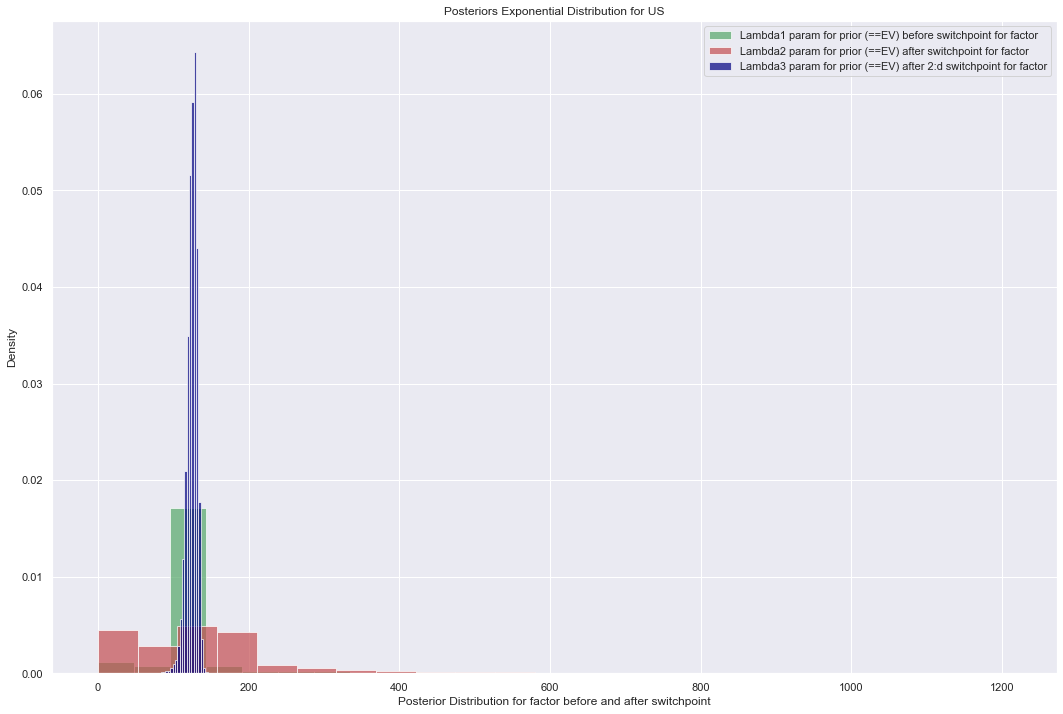

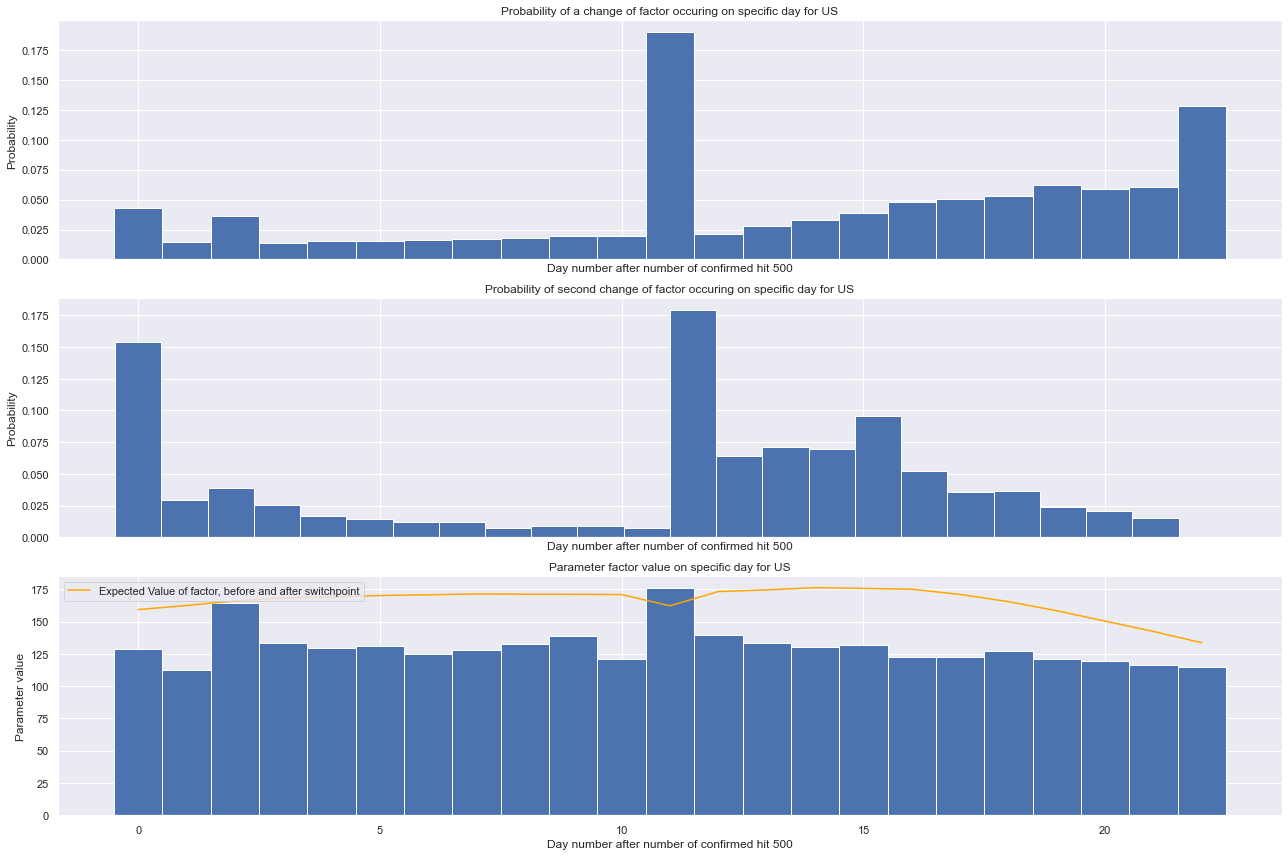

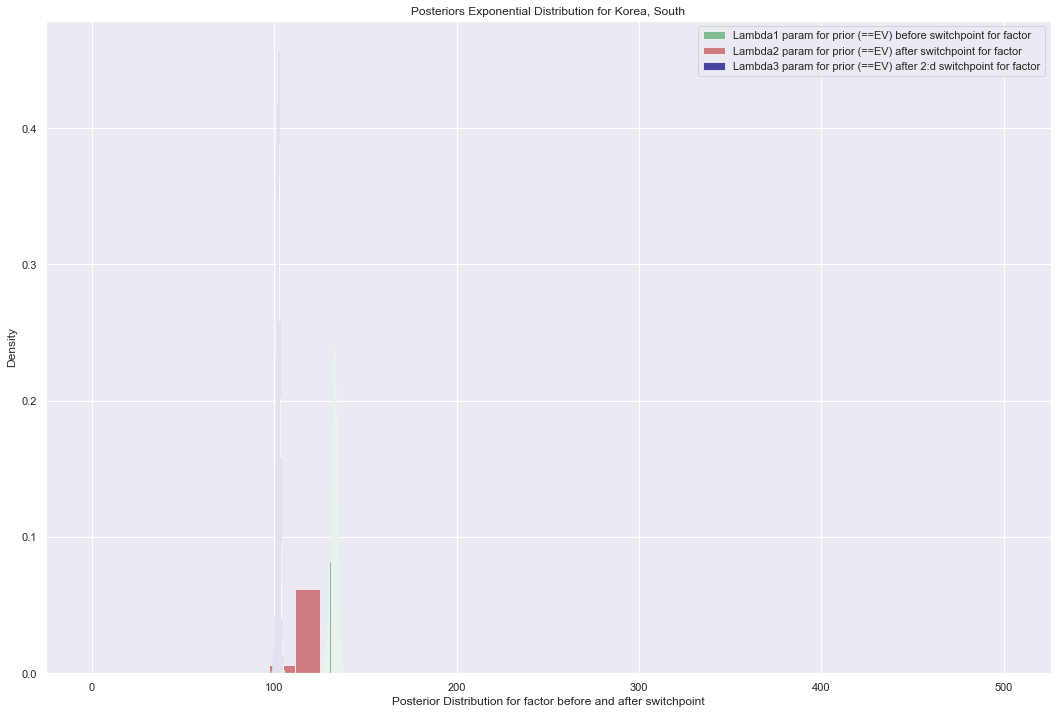

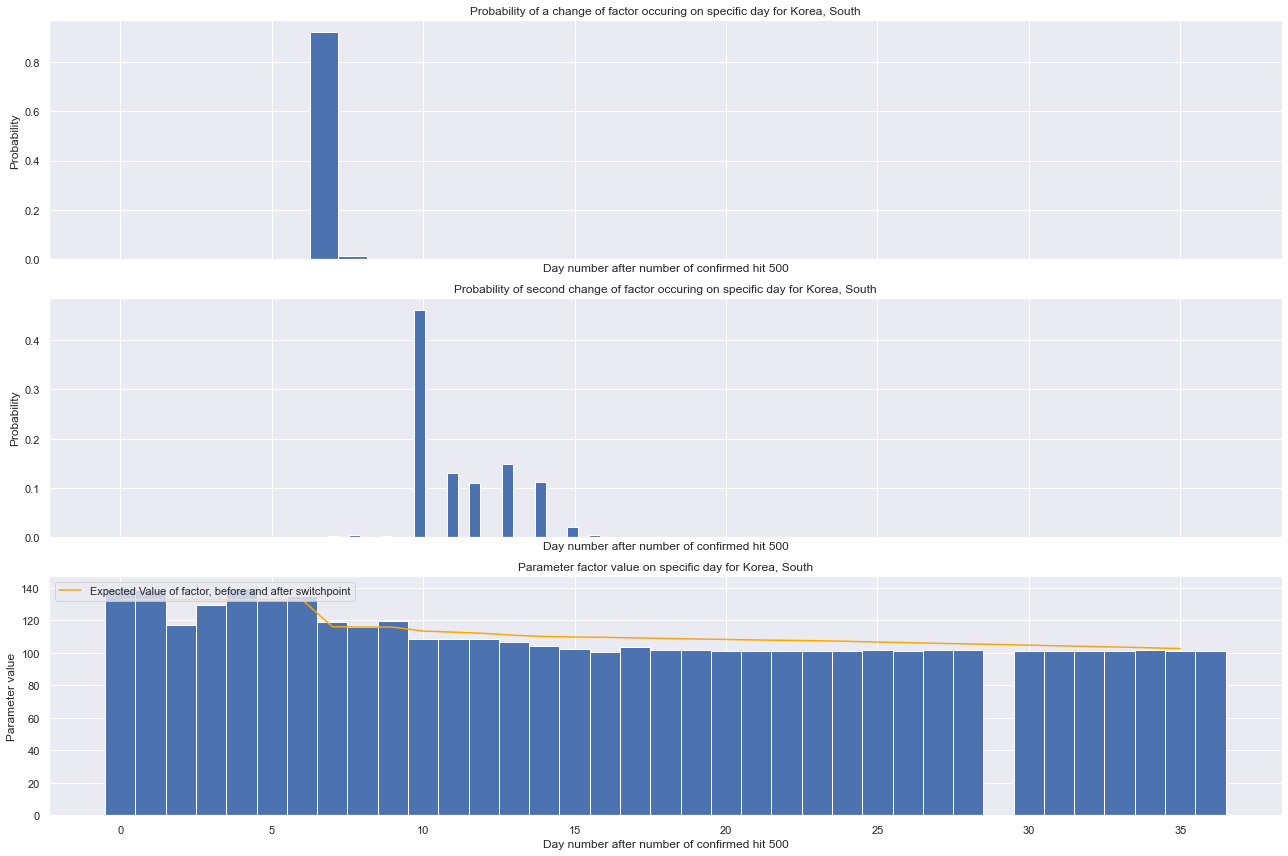

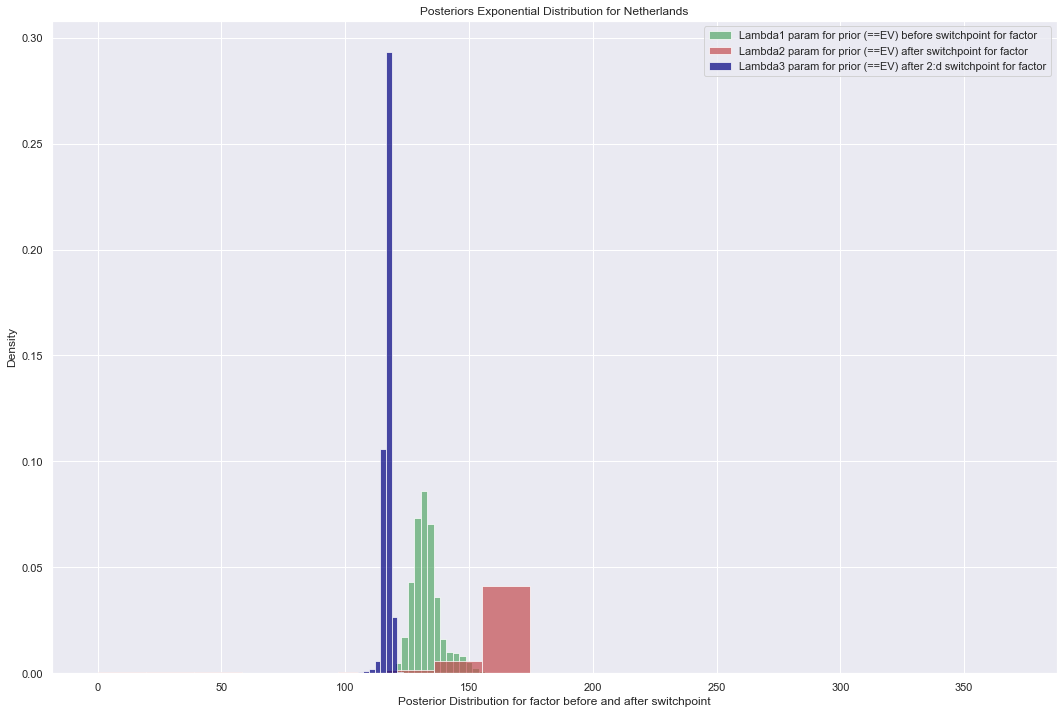

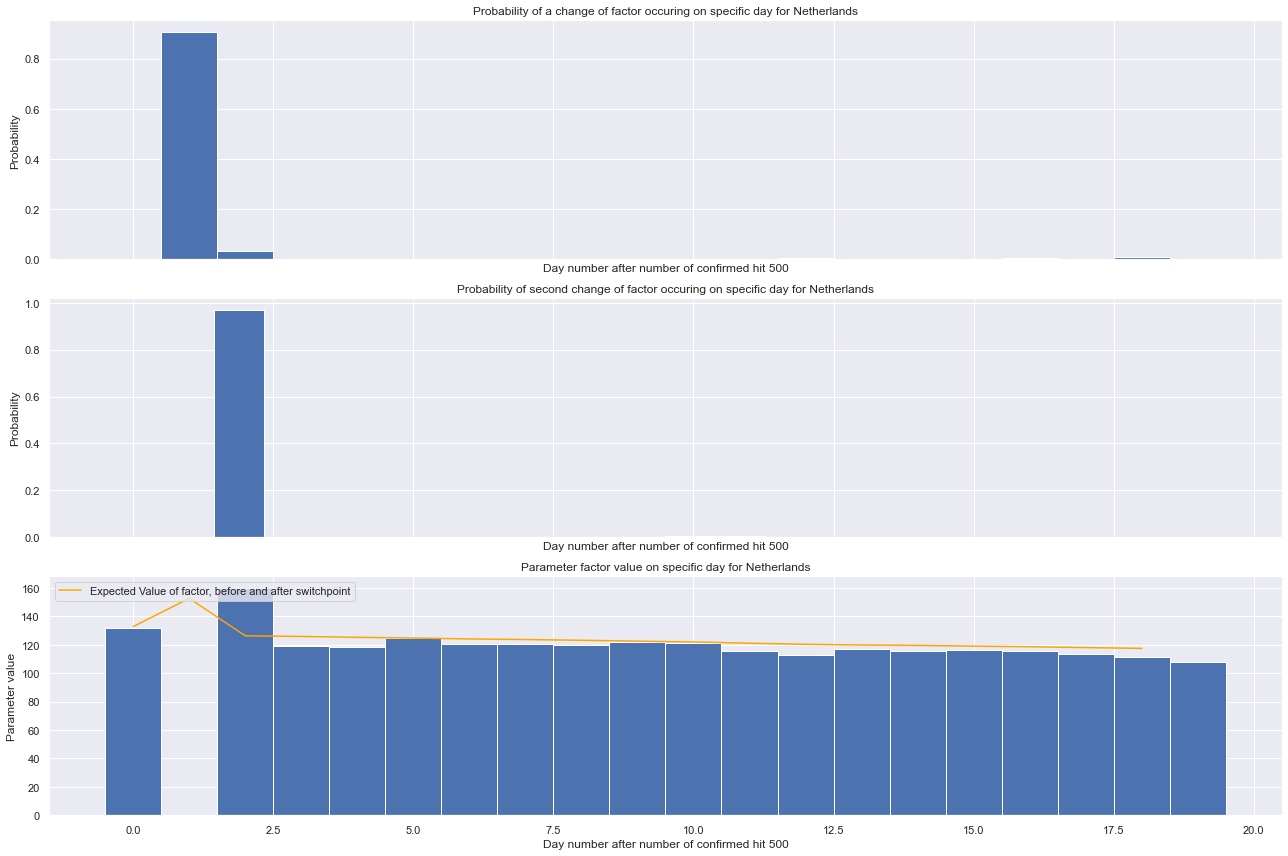

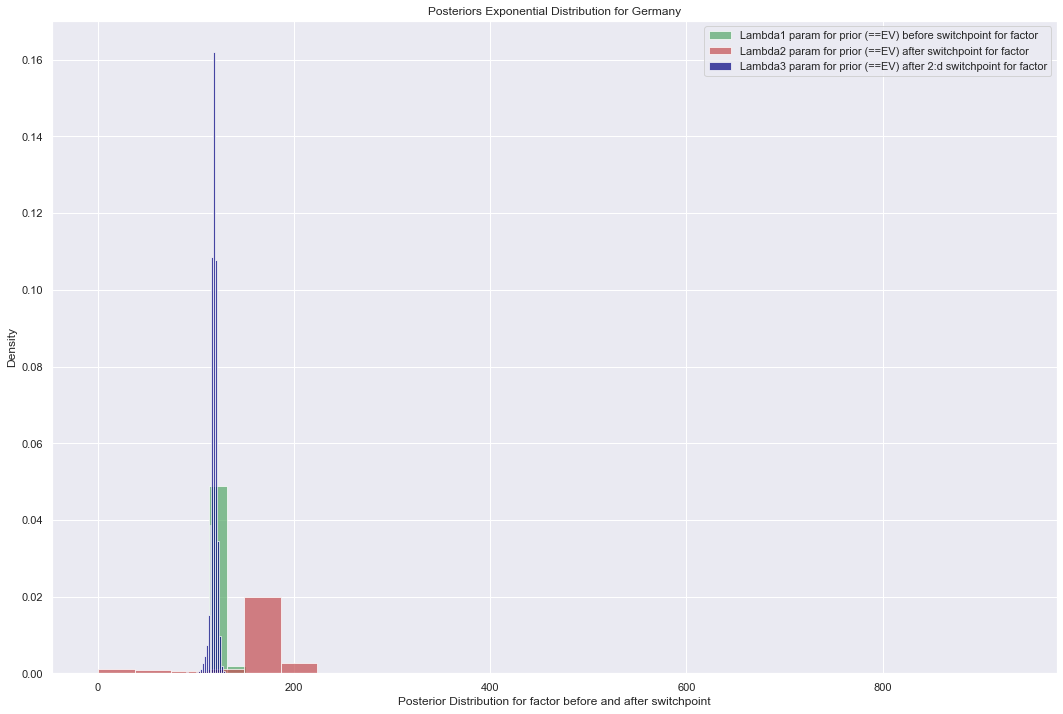

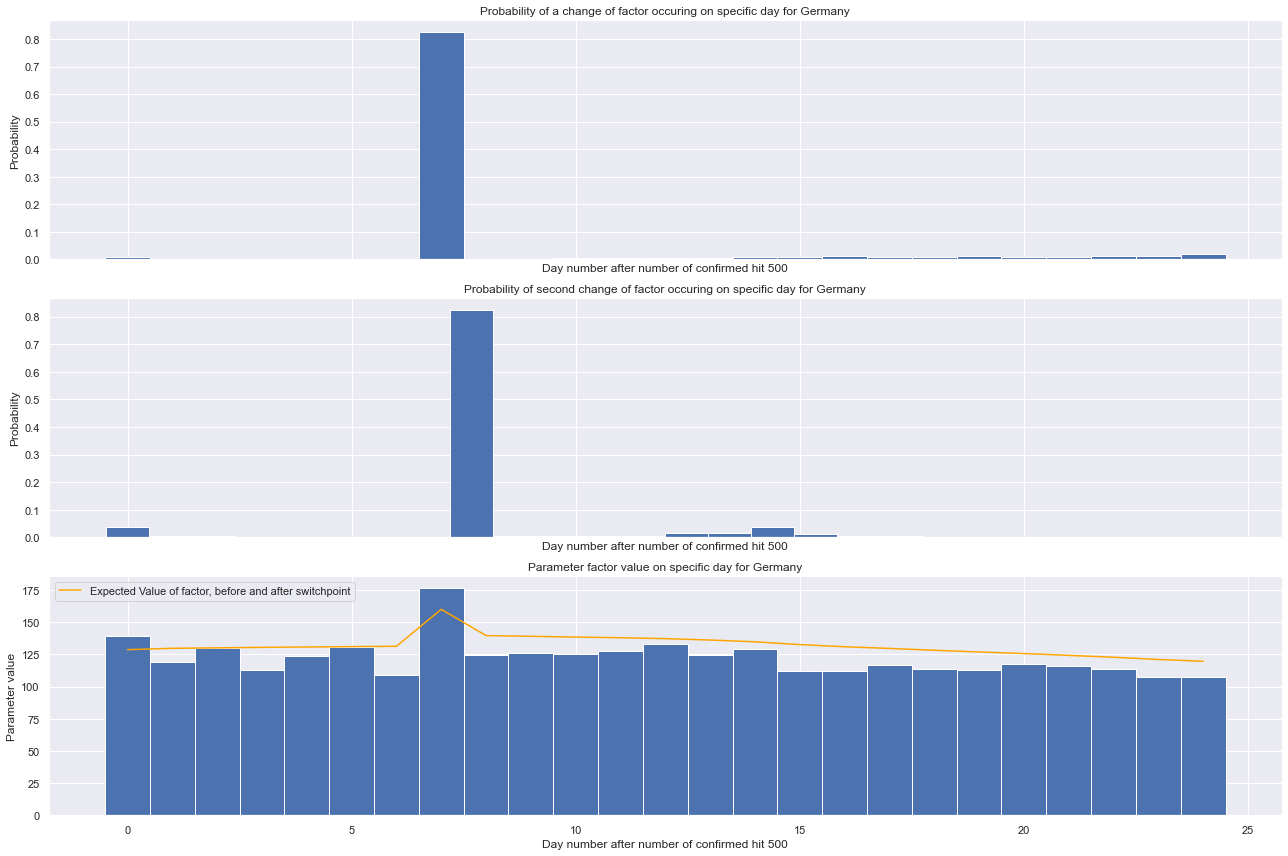

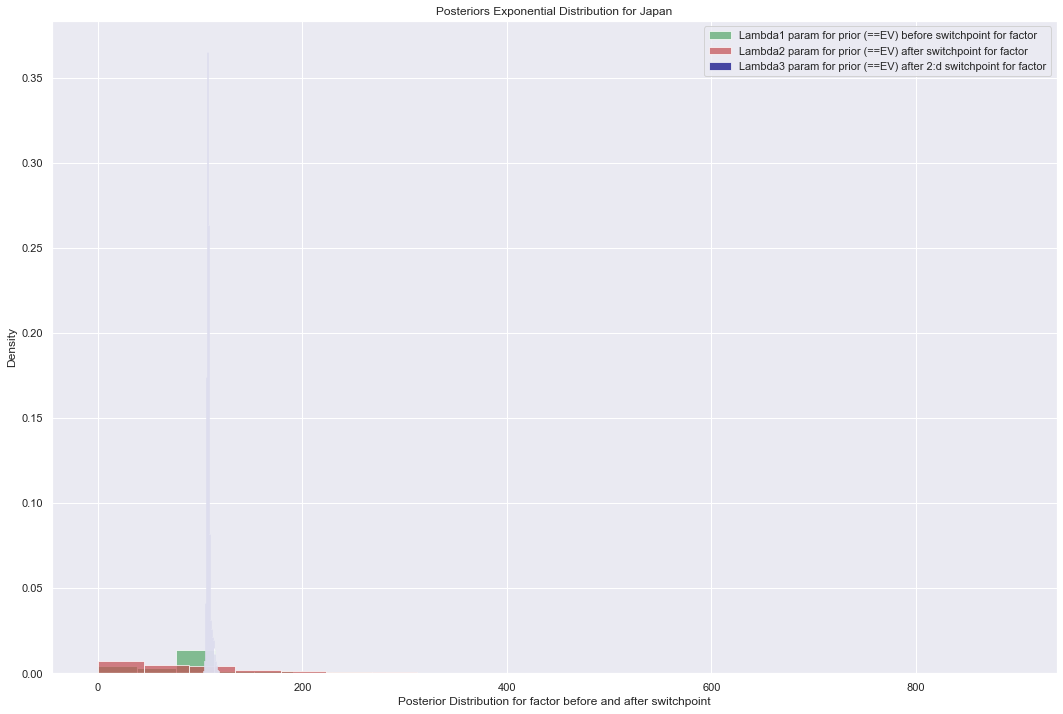

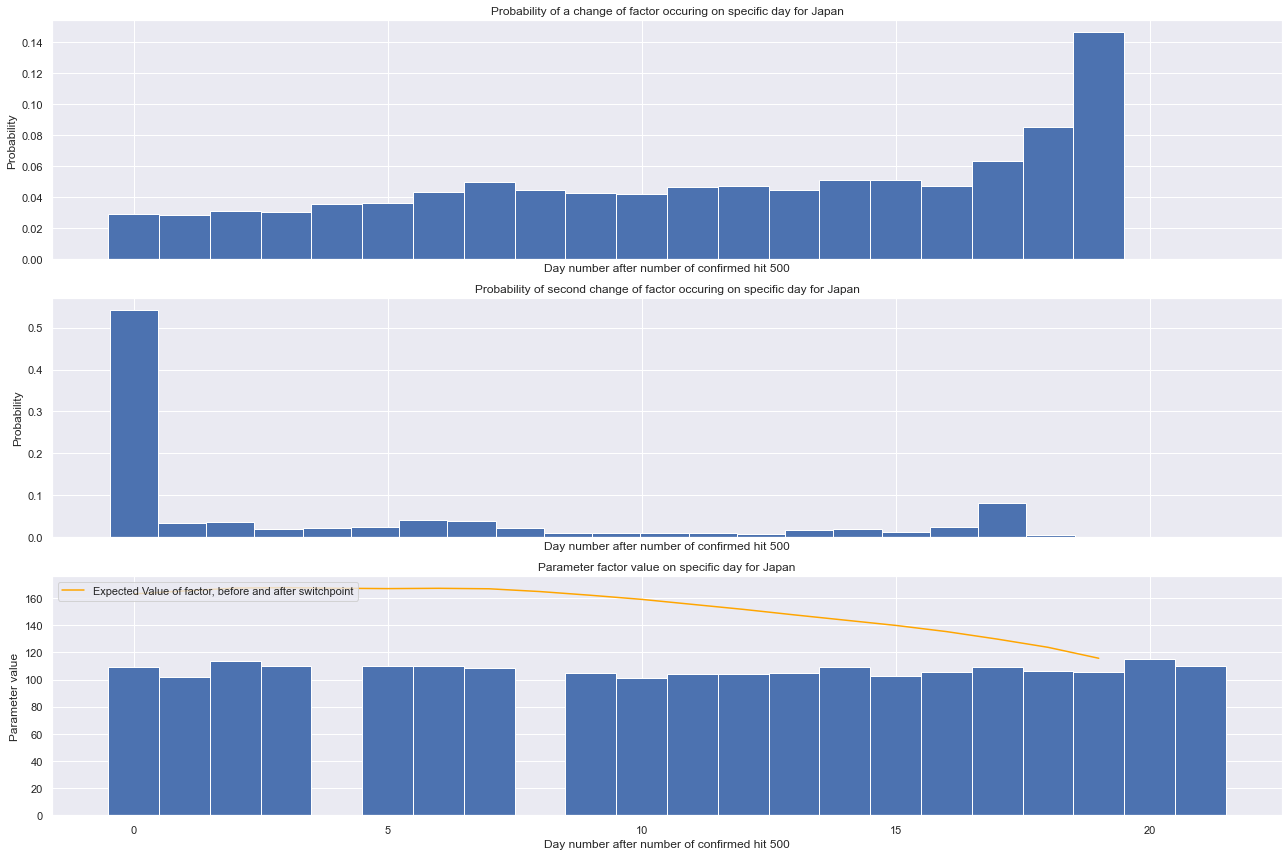

In [4]:
dick = pd.read_pickle('country_data.pkl')

def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})


countries = ['Italy','Spain','Sweden','US','Korea, South','Netherlands','Germany','Japan']

#limit = 10 # first 10 days after passing 5 deceased

filter = 500

for country_name in countries:

    df = dick[country_name]  

    population = country_populations.loc[country_name,'population']
    df['conf_per_M'] = df['confirmed'] / (population / 1e6)
    df['dead_per_M'] = df['deceased'] / (population / 1e6)
    
    df['factor_ratio'] = df['dead_factor'] / df['factor']
    
    ####### SCALE UP FACTOR for better resolution #######
    df['factor'] *= 100 # scaling up provides better resolution, apparently
    df['dead_factor'] *= 100
    ####### 

    df['day_nr'] = np.arange(len(df))

    mask = df['confirmed'] > filter
    
    df = df[mask].copy()
    df['day_nr'] = np.arange(len(df))

    df = df[~df.duplicated('confirmed',keep='first')]
    #df = df[:limit]
    
    print()
    print ('++++++++++   {}   +++++++++++'.format(country_name))
    #print (df.tail(20))
    
    param = 'factor'
    
    data = df[param]
    
    result = switchpoint(data,country_name)
    if result is not None:
        plot(data,df,result,param,country_name)


 [-----------------100%-----------------] 100000 of 100000 complete in 46.5 sec
       lambda_1_post  lambda_2_post  lambda_3_post      tau_post    tau_2_post
count   25000.000000   25000.000000   25000.000000  25000.000000  25000.000000
mean      145.260022     156.286537     121.836776      8.104120      8.003840
std        33.803858     101.318304       8.618757      5.041204      2.447477
min         0.120092       0.006478      49.019498      0.000000      0.000000
25%       137.070167      98.631040     117.331023      3.000000      6.000000
50%       145.991828     161.371806     122.588046      7.000000      8.000000
75%       153.387155     198.844179     127.096648     13.000000      9.000000
max       650.080744    1387.171766     159.150304     17.000000     16.000000
0     124.703088
1     139.428571
2     132.103825
3     176.421923
4     146.248535
5     215.030060
6     154.892824
7     140.914561
8     134.927412
9     132.177215
10    122.969738
11    120.092676
12   

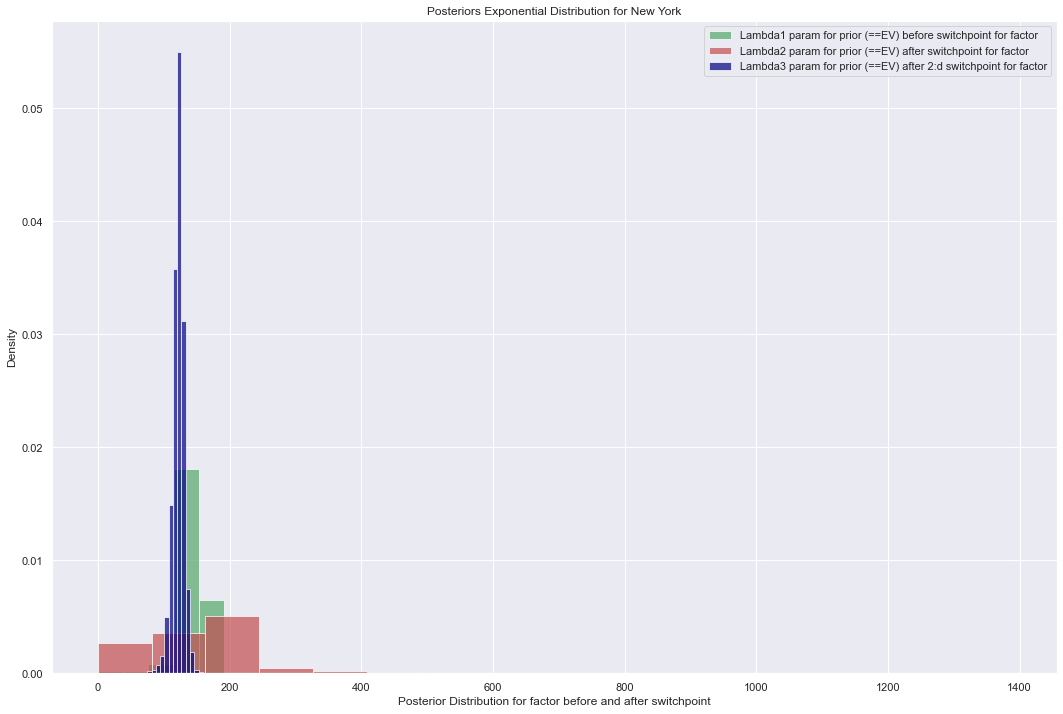

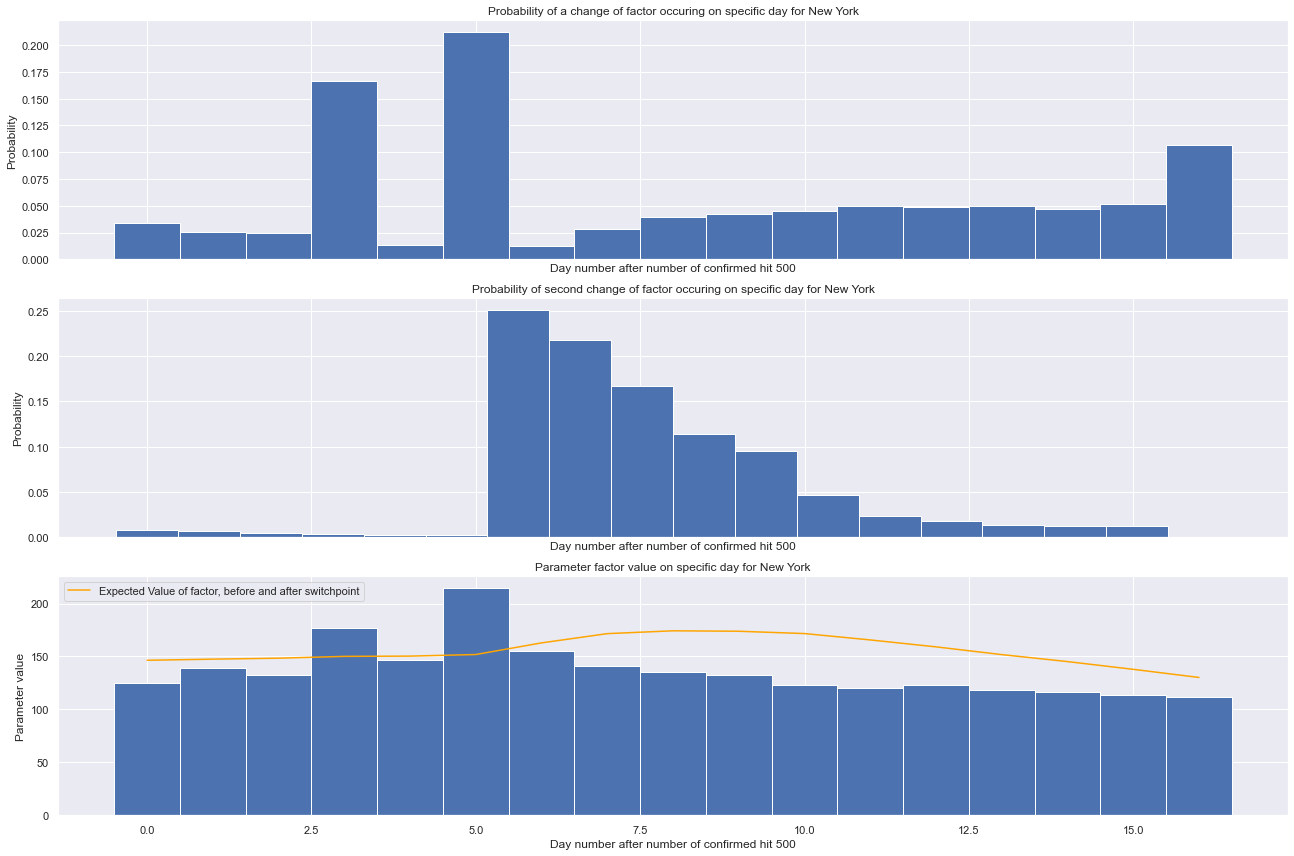

In [5]:
ny = pd.read_pickle('ny_timeline.pkl')
ny = ny[ny['confirmed'] > 500]
ny.reset_index(inplace=True)

ny['factor'] *= 100 # scale up

ny['day_nr'] = np.arange(len(ny))

param = 'factor'
data = ny[param]

result = switchpoint(data,'New York')
plot(data,ny,result,param,'New York')

print (ny.tail(40))